In [60]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sbi.inference import NPE
import torch

In [61]:
# Define system of equations
def mass_spring_damper(y, t, m, k, b):
    x, v = y
    F = np.interp(t, t_data, x_data[0, :, 0])
    dxdt = v
    dvdt = (F - b * v - k * x) / m
    return [dxdt, dvdt]

# Define the input signal (e.g., sinusoidal)
def input_signal(t):
    return 10 * np.sin(2 * np.pi * 0.5 * t)  # Amplitude 10, frequency 0.5 Hz



def mass_spring_damper_simulator(params):
    m, k, b = params
    t = np.linspace(0, 10, num_timesteps)  # Simulation time steps
    
    # Generate positive or non-negative input force
    F = np.cumsum(np.random.rand(num_timesteps) - 0.25)
    F = np.maximum(F, 0)

    # Solve the system
    x0 = [0, 0]  # Initial position and velocity
    sol = odeint(mass_spring_damper, x0, t, args=(m, k, b))

    # Extract state variables
    x = sol[:, 0]
    v = sol[:, 1]

    # Get summary statistics
    stats = extract_summary_statistics(t, x, v)

    return stats



def extract_summary_statistics(t, x, v):
    steady_state = x[-1]

    # Settling time
    settling_idx = np.where(np.abs(x - steady_state) <= 0.05 * np.abs(steady_state))[0]
    settling_time = t[settling_idx[0]] if len(settling_idx) > 0 else np.nan

    # Rise time (time to go from 10% to 90% of final value)
    try:
        rise_start = np.where(x >= 0.1 * steady_state)[0][0]
        rise_end = np.where(x >= 0.9 * steady_state)[0][0]
        rise_time = t[rise_end] - t[rise_start]
    except IndexError:
        rise_time = np.nan

    # Peak overshoot
    peak_overshoot = (np.max(x) - steady_state) / steady_state if steady_state != 0 else np.nan

    # Final position and velocity
    final_position = x[-1]
    final_velocity = v[-1]

    # Mean and variance of position and velocity (to handle randomness)
    mean_position = np.mean(x)
    var_position = np.var(x)
    mean_velocity = np.mean(v)
    var_velocity = np.var(v)
    energy = np.sum(x**2)
    max_rate_of_change = np.max(np.diff(x) / np.diff(t))

    # Combine all summary stats into a single vector
    summary_stats = np.array([
        settling_time, rise_time, peak_overshoot,
        final_position, final_velocity,
        mean_position, var_position,
        mean_velocity, var_velocity,
        energy, max_rate_of_change
    ])
    
    # Handle any NaNs with a fallback value (e.g., -1 or zero)
    summary_stats = np.nan_to_num(summary_stats, nan=-1)

    return summary_stats


In [62]:
# Prior distribution for (m, k, b) — assuming you know rough ranges
prior = torch.distributions.Uniform(low=torch.tensor([0.1, 0.1, 0.1]),
                                    high=torch.tensor([10.0, 10.0, 10.0]))

# Convert the simulator to a PyTorch-compatible function
simulator = lambda params: torch.tensor(mass_spring_damper_simulator(params.numpy()), dtype=torch.float32)

# Create inference object
inference = NPE(prior)

In [63]:
# Generate training data
# Generate random input signal

num_samples = 100
t_max = 20
num_timesteps = 64
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)


theta, x = [], []
num_simulations = 100000
for _ in range(num_simulations):
    params = prior.sample().numpy()
    theta.append(params)
    x.append(mass_spring_damper_simulator(params))

In [64]:
theta = torch.tensor(np.array(theta), dtype=torch.float32)
x = torch.tensor(np.array(x), dtype=torch.float32)

In [65]:
# Train the inference network
density_estimator = inference.append_simulations(theta, x).train()

# Build posterior
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 212 epochs.

In [66]:
# Observe a new system response
observed_data = mass_spring_damper_simulator([1.0, 8.0, 0.8])
observed_data = torch.tensor(observed_data, dtype=torch.float32)
# Infer parameters
samples = posterior.sample((100000,), x=observed_data)
m_inferred, k_inferred, b_inferred = samples.mean(dim=0)
print(f"Inferred m, k, b: {m_inferred}, {k_inferred}, {b_inferred}")

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Inferred m, k, b: 0.8646242022514343, 7.9827470779418945, 0.9732488393783569


In [67]:
sample = prior.sample((1,))
observed_data_2 = mass_spring_damper_simulator(sample.numpy()[0])
observed_data_2 = torch.tensor(observed_data_2, dtype=torch.float32)
# Infer parameters
samples_2 = posterior.sample((1000,), x=observed_data_2)
m_inferred_2, k_inferred_2, b_inferred_2 = samples_2.mean(dim=0)
print(f"Sampled  m, k, b: {sample[0][0]}, {sample[0][1]}, {sample[0][2]}")
print(f"Inferred m, k, b: {m_inferred_2}, {k_inferred_2}, {b_inferred_2}")

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampled  m, k, b: 9.05193042755127, 2.303011417388916, 5.348321914672852
Inferred m, k, b: 9.070984840393066, 2.3025312423706055, 5.364500045776367


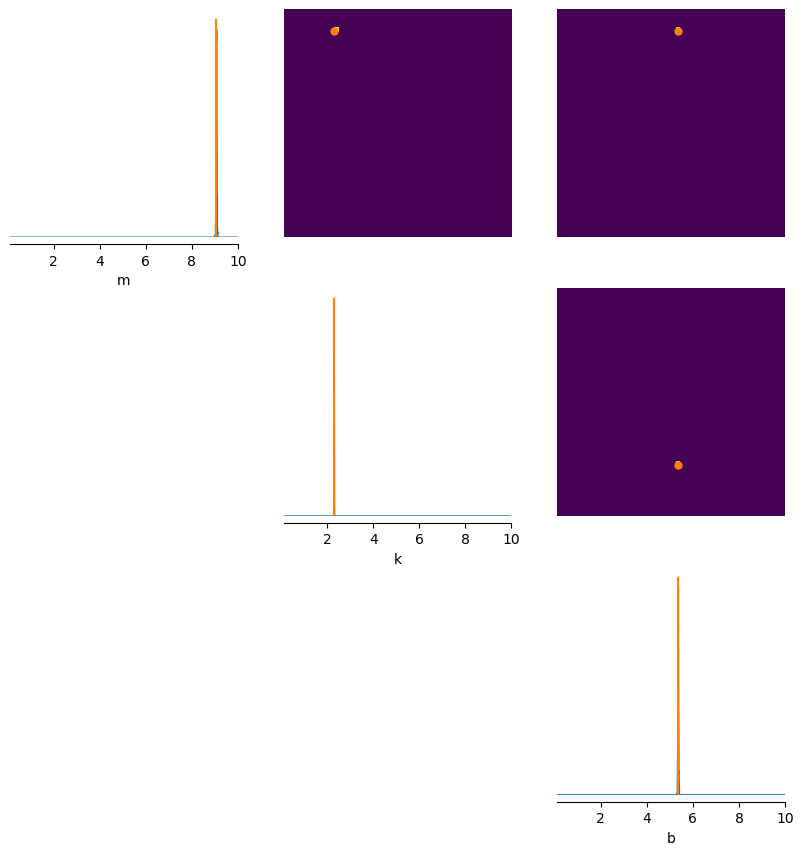

In [68]:
from sbi import analysis

fig, ax = analysis.pairplot(
    samples_2,
    points=sample,
    labels=["m", "k", "b"],
    limits=[[0.1, 10.0], [0.1, 10.0], [0.1, 10.0]]  # Prior limits for m, k, b
)

In [ ]:
# Parameters
m = 10.0   # Mass
k = 5.0    # Spring constant
b = 2.0    # Damping coefficient


# Initial conditions: x0 = 10, v0 = 3
y0 = [10, 3]

# Time range
t = np.linspace(0, 20, 500)

# Solve the system
solution = odeint(mass_spring_damper, y0, t, args=(m, k, b))

# Extract position and velocity
x = solution[:, 0]
v = solution[:, 1]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t, x, label='Position (x)')
plt.plot(t, v, label='Velocity (v)')
plt.xlabel('Time [s]')
plt.ylabel('Response')
plt.legend()
plt.grid()
plt.title('Mass-Spring-Damper System')
plt.show()

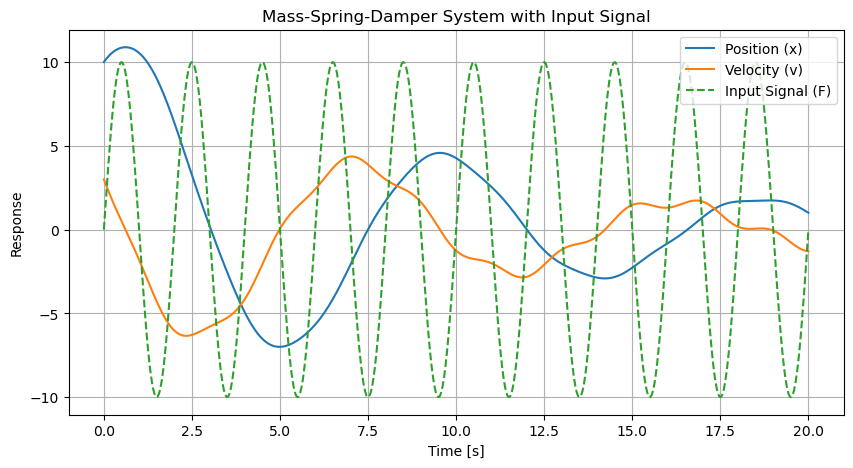

In [ ]:




# Solve the system with the input signal
solution = odeint(mass_spring_damper, y0, t, args=(m, k, b, input_signal))

x = solution[:, 0]
v = solution[:, 1]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t, x, label='Position (x)')
plt.plot(t, v, label='Velocity (v)')
plt.plot(t, input_signal(t), label='Input Signal (F)', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Response')
plt.legend()
plt.grid()
plt.title('Mass-Spring-Damper System with Input Signal')
plt.show()

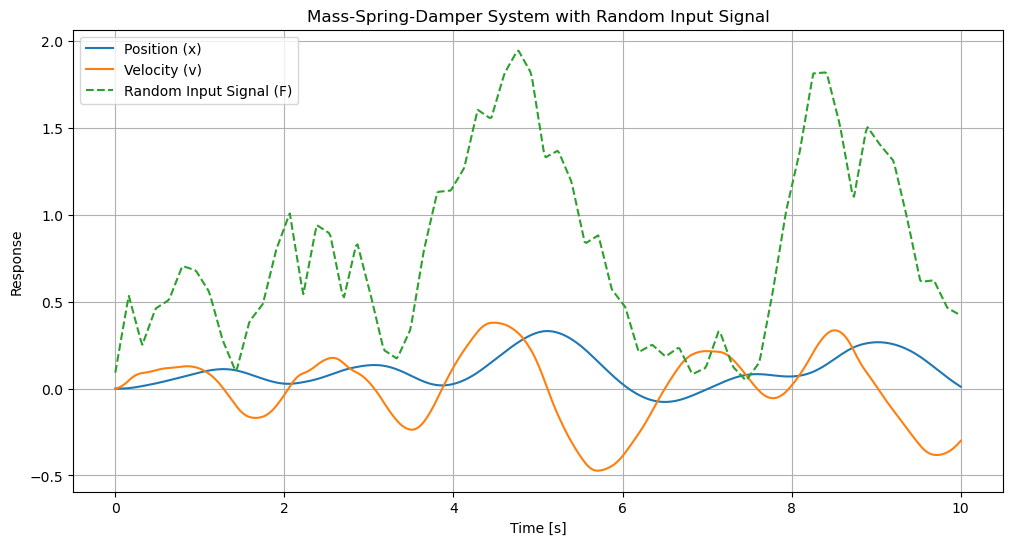

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parameters
m = 1.0   # Mass
k = 8.0    # Spring constant
b = 0.8    # Damping coefficient

# Generate random input signal
num_samples = 1
num_timesteps = 64
t_max = 10

# Create random walk signal
np.random.seed(40)  # For reproducibility
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)

# Interpolate the signal to match time steps used in the ODE solver
t = np.linspace(0, t_max, 500)
input_signal = np.interp(t, t_data, x_data[0, :, 0])




# Initial conditions: x0 = 10, v0 = 3
y0 = [0, 0]

# Solve the system
solution = odeint(mass_spring_damper, y0, t, args=(m, k, b, input_signal))

# Extract position and velocity
x = solution[:, 0]
v = solution[:, 1]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t, x, label='Position (x)')
plt.plot(t, v, label='Velocity (v)')
plt.plot(t, input_signal, label='Random Input Signal (F)', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Response')
plt.legend()
plt.grid()
plt.title('Mass-Spring-Damper System with Random Input Signal')
plt.show()

Summary Statistics: [9.09285933e-03 9.48056545e-02 1.12224449e+00 1.82765531e+01
 1.33373368e+00 8.38336211e-01 0.00000000e+00]


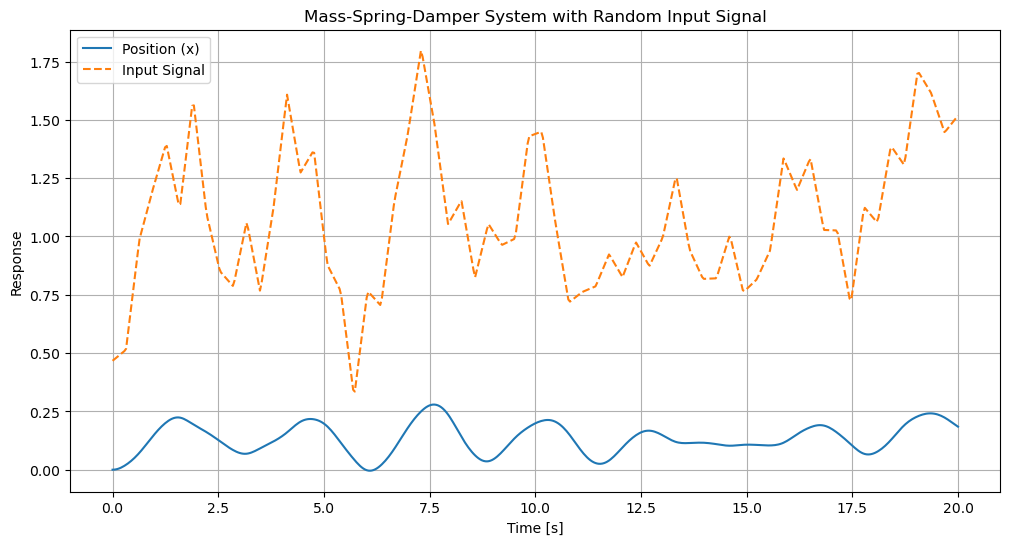

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parameters
m = 1.0
k = 8.0
b = 0.8
# m = 10.0
# k = 5.0
# b = 2.0



np.random.seed(4)



# Interpolate input signal to match time resolution
t = np.linspace(0, t_max, 500)
input_signal = np.interp(t, t_data, x_data[0, :, 0])



# Initial conditions
y0 = [0, 0]
solution = odeint(mass_spring_damper, y0, t, args=(m, k, b, input_signal))

# Extract position and velocity
x = solution[:, 0]
v = solution[:, 1]

# Compute summary statistics
# 1. Gradient as a measure of response rate
input_gradient = np.gradient(input_signal, t)
output_gradient = np.gradient(x, t)

# 2. Overshoot (max value relative to steady-state)
overshoot = np.max(x) - x[-1]

# 3. Settling time (time to reach within 5% of steady-state)
steady_state = x[-1]
settling_time_idx = np.where(np.abs(x - steady_state) <= 0.05 * steady_state)[0][0]
settling_time = t[settling_time_idx]

# 4. Rise time (time to go from 10% to 90% of final value)
rise_time_idx = np.where((x >= 0.1 * steady_state) & (x <= 0.9 * steady_state))[0]
if len(rise_time_idx) > 0:
    rise_time = t[rise_time_idx[-1]] - t[rise_time_idx[0]]
else:
    rise_time = np.nan

# 5. Steady-state error
steady_state_error = np.abs(x[-1] - input_signal[-1])

# 6. Cross-correlation between input and output
cross_corr = np.correlate(input_signal - np.mean(input_signal), x - np.mean(x), mode='full')
cross_corr = np.max(cross_corr) / (np.std(input_signal) * np.std(x) * len(x))

# 7. Frequency response using FFT
freq_response = np.fft.fft(x)
freqs = np.fft.fftfreq(len(t), t[1] - t[0])

# Take the magnitude of the dominant frequency
dominant_frequency = freqs[np.argmax(np.abs(freq_response))]

# Package into summary statistics
summary_stats = np.array([
    np.mean(output_gradient),        # Mean response rate
    overshoot,
    settling_time,
    rise_time,
    steady_state_error,
    cross_corr,
    dominant_frequency
])

print(f"Summary Statistics: {summary_stats}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t, x, label='Position (x)')
plt.plot(t, input_signal, label='Input Signal', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Response')
plt.legend()
plt.grid()
plt.title('Mass-Spring-Damper System with Random Input Signal')
plt.show()



2025-05-07 08:45:34.722679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746600334.735027    5795 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746600334.738702    5795 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746600334.747784    5795 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746600334.747799    5795 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746600334.747800    5795 computation_placer.cc:177] computation placer alr

 Neural network successfully converged after 300 epochs.

In [6]:
# Observe a new system response
observed_data = mass_spring_damper_simulator([1.0, 8.0, 0.8])
observed_data = torch.tensor(observed_data, dtype=torch.float32)
# Infer parameters
samples = posterior.sample((1000,), x=observed_data)
m_inferred, k_inferred, b_inferred = samples.mean(dim=0)
print(f"Inferred m, k, b: {m_inferred}, {k_inferred}, {b_inferred}")

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Inferred m, k, b: 0.7173910140991211, 8.02039909362793, 0.6026661396026611


In [7]:
sample = prior.sample((1,))
observed_data_2 = mass_spring_damper_simulator(sample.numpy()[0])
observed_data_2 = torch.tensor(observed_data_2, dtype=torch.float32)
# Infer parameters
samples_2 = posterior.sample((1000,), x=observed_data_2)
m_inferred_2, k_inferred_2, b_inferred_2 = samples_2.mean(dim=0)
print(f"Sampled  m, k, b: {sample[0][0]}, {sample[0][1]}, {sample[0][2]}")
print(f"Inferred m, k, b: {m_inferred_2}, {k_inferred_2}, {b_inferred_2}")

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampled  m, k, b: 5.424922466278076, 7.54151725769043, 5.917486667633057
Inferred m, k, b: 5.443782329559326, 7.5368757247924805, 5.9319024085998535


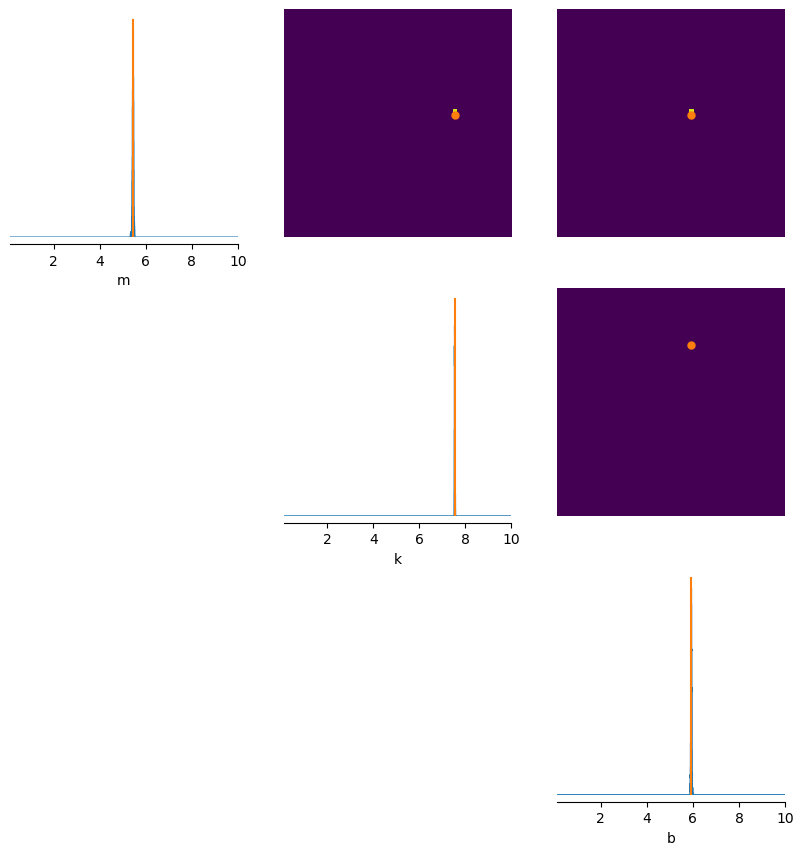

In [8]:
from sbi import analysis

fig, ax = analysis.pairplot(
    samples_2,
    points=sample,
    labels=["m", "k", "b"],
    limits=[[0.1, 10.0], [0.1, 10.0], [0.1, 10.0]]  # Prior limits for m, k, b
)